In [1]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

palette = sns.xkcd_palette(["medium green", "steel"])

## single locus plots

In [4]:
ds = pl.read_parquet("output/sim_single").with_columns(
    (pl.col("m_a") / (2 * pl.col("num_individuals"))).alias("pA"),
    (pl.col("nA") / (2 * pl.col("nSeed"))).alias("pA0"),
    (pl.col("cycle") - 1).alias("gen"),
    pl.format("{}", 1 + pl.col("selExpA")).alias("sExpA"),
    pl.format("{}", 1 + pl.col("selTruncA")).alias("sTruncA"),
)

g = sns.FacetGrid(
    ds.with_columns(
        pl.col("sTruncA").alias("$s_{\\text{truncation}}$"),
        pl.col("sExpA").alias("$s_{\\text{expansion}}$"),
    ),
    row="$s_{\\text{truncation}}$",
    col="$s_{\\text{expansion}}$",
    sharex=True,
    sharey=True,
    margin_titles=True,
)

g.map(sns.lineplot, "gen", "pA", color=palette[0])
g.set_ylabels("Allele frequency")
g.set_xlabels("Generation")
g.add_legend()

for ax in g.axes.flat:
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
    g.refline(x=9)


g.savefig("submission_plots/single_locus.png", bbox_inches="tight", dpi=600)
g.savefig("submission_plots/single_locus.pdf", bbox_inches="tight")

plt.close(g.figure)

## two loci, trajectories by linkage

In [5]:
d = (
    pl.read_parquet("output/sim")
    .with_columns(
        (pl.col("m_a") / (2 * pl.col("num_individuals"))).alias("pA"),
        (pl.col("m_b") / (2 * pl.col("num_individuals"))).alias("pB"),
        (pl.col("m_ab") / (2 * pl.col("num_individuals"))).alias("pAB"),
        (pl.col("nA") / (2 * pl.col("nSeed"))).alias("pA0"),
        (pl.col("nB") / (2 * pl.col("nSeed"))).alias("pB0"),
        (pl.col("nAB") / (2 * pl.col("nSeed"))).alias("pAB0"),
        (pl.col("cycle") - 1).alias("gen"),
        pl.col("r").pow(2).alias("rsq"),
        pl.format("{}", 1 + pl.col("selExpA")).alias("sExpA"),
        pl.format("{}", 1 + pl.col("selExpB")).alias("sExpB"),
        pl.format("{}", 1 + pl.col("selTruncA")).alias("sTruncA"),
        pl.format("{}", 1 + pl.col("selTruncB")).alias("sTruncB"),
        (pl.col("mutPosB") - pl.col("mutPosA")).abs().alias("distance"),
    )
    .with_columns(
        (
            (pl.col("pAB0") - pl.col("pA0") * pl.col("pB0")).pow(2)
            / (
                pl.col("pA0")
                * (1 - pl.col("pA0"))
                * pl.col("pB0")
                * (1 - pl.col("pB0"))
            )
        ).alias("rsq_direct"),
        pl.col("rsqCategory")
        .replace_strict({-1: "repulsion", 0: "unlinked", 1: "attraction"})
        .alias("linkage"),
    )
    .select(
        "distance",
        "sExpA",
        "sTruncB",
        "pA0",
        "pB0",
        "pAB0",
        "linkage",
        "r",
        "rsq_direct",
        "replicate",
        "gen",
        "pA",
        "pB",
        "pAB",
    )
    .sort("distance", "sExpA", "sTruncB", "pA0", "pB0", "r", "replicate", "gen")
)

df = (
    d.to_pandas()
    .melt(
        id_vars=[
            "linkage",
            "distance",
            "sExpA",
            "sTruncB",
            "pA0",
            "pB0",
            "replicate",
            "gen",
        ],
        value_vars=["pA", "pB"],
        var_name="locus",
        value_name="p",
    )
    .sort_values(by=["sExpA", "sTruncB", "distance", "linkage", "replicate", "gen"])
)
df["locus"] = df["locus"].apply(lambda x: x[1])


distances = df["distance"].unique()
linkages = df["linkage"].unique()

In [6]:
distance = 1e6  # plot for 1 Mb
for link in linkages:
    dplot = df.query("distance == @distance and linkage == @link")

    g = sns.FacetGrid(
        dplot.rename(
            columns={
                "sTruncB": "$s_{\\text{truncation}}^{(B)}$",
                "sExpA": "$s_{\\text{expansion}}^{(A)}$",
            }
        ),
        row="$s_{\\text{truncation}}^{(B)}$",
        col="$s_{\\text{expansion}}^{(A)}$",
        sharex=True,
        sharey=True,
        margin_titles=True,
    )

    g.map(sns.lineplot, "gen", "p", "locus", palette=palette)
    g.set_ylabels("Allele frequency")
    g.set_xlabels("Generation")
    g.add_legend(title="Locus")

    for ax in g.axes.flat:
        ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
    g.refline(x=9)

    g.savefig(f"submission_plots/two_loci_1Mb_{link}.png", bbox_inches="tight", dpi=600)
    g.savefig(f"submission_plots/two_loci_1Mb_{link}.pdf", bbox_inches="tight")

    plt.close(g.figure)

## two loci, combined trajectories

In [7]:
distance = 1e6
dplot = df.query("distance == @distance")

g = sns.FacetGrid(
    dplot.rename(
        columns={
            "sTruncB": "$s_{\\text{truncation}}^{(B)}$",
            "sExpA": "$s_{\\text{expansion}}^{(A)}$",
        }
    ),
    row="$s_{\\text{truncation}}^{(B)}$",
    col="$s_{\\text{expansion}}^{(A)}$",
    sharex=True,
    sharey=True,
    margin_titles=True,
)

g.map(sns.lineplot, "gen", "p", "locus", palette=palette)
g.set_ylabels("Allele frequency")
g.set_xlabels("Generation")
g.add_legend(title="Locus")

for ax in g.axes.flat:
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
g.refline(x=9)

g.savefig("submission_plots/two_loci_1Mb_combined.png", bbox_inches="tight", dpi=600)
g.savefig("submission_plots/two_loci_1Mb_combined.pdf", bbox_inches="tight")

plt.close(g.figure)

## two loci, fitness estimates by linkage

In [30]:
d = (
    pl.read_parquet("output/sim")
    .with_columns(
        (pl.col("m_a") / (2 * pl.col("num_individuals"))).alias("pA"),
        (pl.col("m_b") / (2 * pl.col("num_individuals"))).alias("pB"),
        (pl.col("m_ab") / (2 * pl.col("num_individuals"))).alias("pAB"),
        (pl.col("nA") / (2 * pl.col("nSeed"))).alias("pA0"),
        (pl.col("nB") / (2 * pl.col("nSeed"))).alias("pB0"),
        (pl.col("nAB") / (2 * pl.col("nSeed"))).alias("pAB0"),
        (pl.col("cycle") - 1).alias("gen"),
        pl.col("r").pow(2).alias("rsq"),
        pl.format("{}", 1 + pl.col("selExpA")).alias("sExpA"),
        pl.format("{}", 1 + pl.col("selExpB")).alias("sExpB"),
        pl.format("{}", 1 + pl.col("selTruncA")).alias("sTruncA"),
        pl.format("{}", 1 + pl.col("selTruncB")).alias("sTruncB"),
        (pl.col("mutPosB") - pl.col("mutPosA")).abs().alias("distance"),
    )
    .with_columns(
        (
            (pl.col("pAB0") - pl.col("pA0") * pl.col("pB0")).pow(2)
            / (
                pl.col("pA0")
                * (1 - pl.col("pA0"))
                * pl.col("pB0")
                * (1 - pl.col("pB0"))
            )
        ).alias("rsq_direct"),
        pl.col("rsqCategory")
        .replace_strict({-1: "repulsion", 0: "unlinked", 1: "attraction"})
        .alias("linkage"),
    )
    .select(
        "distance",
        "sExpA",
        "sTruncB",
        "pA0",
        "pB0",
        "pAB0",
        "linkage",
        "r",
        "rsq_direct",
        "replicate",
        "gen",
        "pA",
        "pB",
        "pAB",
    )
    .sort("distance", "sExpA", "sTruncB", "pA0", "pB0", "r", "replicate", "gen")
)

# expansion selection is estimated from all generations
ds_exp = (
    d.filter((pl.col("gen") <= 9))
    .sort(["distance", "sExpA", "sTruncB", "linkage", "replicate", "gen"])
    .group_by("distance", "sExpA", "sTruncB", "linkage", "replicate")
    .agg(pl.col("pA"), pl.col("pB"))
    .with_columns(
        pl.col("pA").list.first().alias("pA0"),
        pl.col("pA").list.last().alias("pAT"),
        pl.col("pA")
        .list.head(9)
        .list.eval(pl.element() * (1 - pl.element()))
        .list.sum()
        .alias("denumA"),
        pl.col("pB").list.first().alias("pB0"),
        pl.col("pB").list.last().alias("pBT"),
        pl.col("pB")
        .list.head(9)
        .list.eval(pl.element() * (1 - pl.element()))
        .list.sum()
        .alias("denumB"),
    )
    .with_columns(
        # times two used here, but not in Mathieson & McVean (2013)
        # because they set homozygote fitness to 1 + 2s and SLiM sets it to 1 + s
        # because of that all our estimates are halved without this multiple
        (pl.col("pAT") - pl.col("pA0")).mul(2).truediv(pl.col("denumA")).alias("sA"),
        (pl.col("pBT") - pl.col("pB0")).mul(2).truediv(pl.col("denumB")).alias("sB"),
    )
    .sort(["distance", "sExpA", "sTruncB", "linkage", "replicate"])
    .unpivot(
        index=["linkage", "replicate", "distance", "sExpA", "sTruncB"],
        on=["sA", "sB"],
        variable_name="locus",
        value_name="s",
    )
    .with_columns(pl.col("distance"), pl.col("locus").str.strip_prefix("s"))
    .to_pandas()
)


# truncation selection is estimated from the first generation only
ds_trunc = (
    d.filter((pl.col("gen") >= 9) & (pl.col("gen") < 11))
    .sort(["distance", "sExpA", "sTruncB", "linkage", "replicate", "gen"])
    .group_by("distance", "sExpA", "sTruncB", "linkage", "replicate")
    .agg(
        pl.col("pA").first().alias("pA0"),
        pl.col("pA").last().alias("pAT"),
        pl.col("pB").first().alias("pB0"),
        pl.col("pB").last().alias("pBT"),
    )
    .with_columns(
        # times two used here, but not in Mathieson & McVean (2013)
        # because they set homozygote fitness to 1 + 2s and SLiM sets it to 1 + s
        # because of that all our estimates are halved without this multiple
        (
            2 * (pl.col("pAT") - pl.col("pA0")) / (pl.col("pA0") * (1 - pl.col("pA0")))
        ).alias("sA"),
        (
            2 * (pl.col("pBT") - pl.col("pB0")) / (pl.col("pB0") * (1 - pl.col("pB0")))
        ).alias("sB"),
    )
    .sort(["distance", "sExpA", "sTruncB", "linkage", "replicate"])
    .unpivot(
        index=["linkage", "replicate", "distance", "sExpA", "sTruncB"],
        on=["sA", "sB"],
        variable_name="locus",
        value_name="s",
    )
    .with_columns(pl.col("distance"), pl.col("locus").str.strip_prefix("s"))
    .to_pandas()
)

In [ ]:
# bootstrap

boots_exp = []
boots_trunc = []

for i in tqdm(range(1000)):
    boots_exp.append(
        ds_exp.groupby(["distance", "sTruncB", "sExpA", "linkage", "locus"])
        .sample(frac=1, replace=True)
        .groupby(["distance", "sTruncB", "sExpA", "linkage", "locus"])
        .agg({"s": "mean"})
        .reset_index()
    )

    boots_trunc.append(
        ds_trunc.groupby(["distance", "sTruncB", "sExpA", "linkage", "locus"])
        .sample(frac=1, replace=True)
        .groupby(["distance", "sTruncB", "sExpA", "linkage", "locus"])
        .agg({"s": "mean"})
        .reset_index()
    )

dboot_exp = (
    pd.concat(boots_exp)
    .groupby(["distance", "sTruncB", "sExpA", "linkage", "locus"])["s"]
    .quantile([0.025, 0.5, 0.975])
    .unstack()
    .reset_index()
)

dboot_trunc = (
    pd.concat(boots_trunc)
    .groupby(["distance", "sTruncB", "sExpA", "linkage", "locus"])["s"]
    .quantile([0.025, 0.5, 0.975])
    .unstack()
    .reset_index()
)

In [23]:
def plot_ebars(*, data, **kwargs):
    ax = plt.gca()
    palette = sns.xkcd_palette(["medium green", "steel"])
    da = data.query("locus== 'A'")
    db = data.query("locus== 'B'")

    x = (da["distance"] / 1e6).astype(str)
    y = 1 + da[0.5]
    yerr = (y - (1 + da[0.025]), (1 + da[0.975]) - y)
    ax.errorbar(x=x, y=y, yerr=yerr, color=palette[0], label="A")
    ax.scatter(x, y, color=palette[0])

    x = (db["distance"] / 1e6).astype(str)
    y = 1+ db[0.5]
    yerr = (y - (1 + db[0.025]), (1 + db[0.975]) - y)
    ax.errorbar(x=x, y=y, yerr=yerr, color=palette[1], label="B")
    ax.scatter(x, y, color=palette[1])

In [24]:
for link in ds_exp["linkage"].unique():
    dplt = dboot_exp.query("linkage == @link").sort_values(
        by=["sTruncB", "sExpA", "locus", "distance"]
    )

    g = sns.FacetGrid(
        dplt.rename(
            columns={
                "sTruncB": "$s_{\\text{truncation}}^{(B)}$",
                "sExpA": "$s_{\\text{expansion}}^{(A)}$",
            }
        ),
        row="$s_{\\text{truncation}}^{(B)}$",
        col="$s_{\\text{expansion}}^{(A)}$",
        sharex=True,
        sharey=True,
        margin_titles=True,
    )

    g.map_dataframe(plot_ebars)

    g.add_legend()
    g.set_ylabels("Selection coefficient $\\widetilde{s}$\nduring expansion")
    g.set_xlabels("Distance between A and B, Mb")

    g.refline(y=1)

    g.savefig(
        f"submission_plots/two_loci_expansion_coeff_{link}.png",
        bbox_inches="tight",
        dpi=600,
    )
    g.savefig(
        f"submission_plots/two_loci_expansion_coeff_{link}.pdf", bbox_inches="tight"
    )
    plt.close(g.figure)

for link in ds_trunc["linkage"].unique():
    dplt = dboot_trunc.query("linkage == @link").sort_values(
        by=["sTruncB", "sExpA", "locus", "distance"]
    )

    g = sns.FacetGrid(
        dplt.rename(
            columns={
                "sTruncB": "$s_{\\text{truncation}}^{(B)}$",
                "sExpA": "$s_{\\text{expansion}}^{(A)}$",
            }
        ),
        row="$s_{\\text{truncation}}^{(B)}$",
        col="$s_{\\text{expansion}}^{(A)}$",
        sharex=True,
        sharey=True,
        margin_titles=True,
    )

    g.map_dataframe(plot_ebars)

    g.add_legend()
    g.set_ylabels("Selection coefficient $\\widetilde{s}$\nduring truncation")
    g.set_xlabels("Distance between A and B, Mb")

    g.refline(y=1)

    g.savefig(
        f"submission_plots/two_loci_truncation_coeff_{link}.png",
        bbox_inches="tight",
        dpi=600,
    )
    g.savefig(
        f"submission_plots/two_loci_truncation_coeff_{link}.pdf", bbox_inches="tight"
    )
    plt.close(g.figure)

In [ ]:
boots_exp = []
boots_trunc = []


for i in tqdm(range(1000)):
    boots_exp.append(
        ds_exp.groupby(["distance", "sTruncB", "sExpA", "locus"])
        .sample(frac=1, replace=True)
        .groupby(["distance", "sTruncB", "sExpA", "locus"])
        .agg({"s": "mean"})
        .reset_index()
    )

    boots_trunc.append(
        ds_trunc.groupby(["distance", "sTruncB", "sExpA", "locus"])
        .sample(frac=1, replace=True)
        .groupby(["distance", "sTruncB", "sExpA", "locus"])
        .agg({"s": "mean"})
        .reset_index()
    )

dbootc_exp = (
    pd.concat(boots_exp)
    .groupby(["distance", "sTruncB", "sExpA", "locus"])["s"]
    .quantile([0.025, 0.5, 0.975])
    .unstack()
    .reset_index()
)

dbootc_trunc = (
    pd.concat(boots_trunc)
    .groupby(["distance", "sTruncB", "sExpA", "locus"])["s"]
    .quantile([0.025, 0.5, 0.975])
    .unstack()
    .reset_index()
)


In [27]:
dplt_exp = dbootc_exp.sort_values(by=["sTruncB", "sExpA", "locus", "distance"])

g = sns.FacetGrid(
    dplt_exp.rename(
        columns={
            "sTruncB": "$s_{\\text{truncation}}^{(B)}$",
            "sExpA": "$s_{\\text{expansion}}^{(A)}$",
        }
    ),
    row="$s_{\\text{truncation}}^{(B)}$",
    col="$s_{\\text{expansion}}^{(A)}$",
    sharex=True,
    sharey=True,
    margin_titles=True,
)

g.map_dataframe(plot_ebars)

g.add_legend()
g.set_ylabels("Selection coefficient $\\widetilde{s}$\nduring expansion")
g.set_xlabels("Distance between A and B, Mb")

g.refline(y=1)


g.savefig(
    "submission_plots/two_loci_expansion_coeff_combined.png",
    bbox_inches="tight",
    dpi=600,
)
g.savefig("submission_plots/two_loci_expansion_coeff_combined.pdf", bbox_inches="tight")
plt.close(g.figure)

dplt_trunc = dbootc_trunc.sort_values(by=["sTruncB", "sExpA", "locus", "distance"])

g = sns.FacetGrid(
    dplt_trunc.rename(
        columns={
            "sTruncB": "$s_{\\text{truncation}}^{(B)}$",
            "sExpA": "$s_{\\text{expansion}}^{(A)}$",
        }
    ),
    row="$s_{\\text{truncation}}^{(B)}$",
    col="$s_{\\text{expansion}}^{(A)}$",
    sharex=True,
    sharey=True,
    margin_titles=True,
)

g.map_dataframe(plot_ebars)

g.add_legend()
g.set_ylabels("Selection coefficient $\\widetilde{s}$\nduring truncation")
g.set_xlabels("Distance between A and B, Mb")

g.refline(y=1)


g.savefig(
    "submission_plots/two_loci_truncation_coeff_combined.png",
    bbox_inches="tight",
    dpi=600,
)
g.savefig("submission_plots/two_loci_truncation_coeff_combined.pdf", bbox_inches="tight")
plt.close(g.figure)

### combined plot

In [37]:
dplot = pl.concat([pl.from_pandas(ds_exp).with_columns(pl.lit("Expansion").alias('stage')), pl.from_pandas(ds_trunc).with_columns(pl.lit("Truncation").alias('stage'))]).filter(
    pl.col("distance") == 2e6, pl.col("sExpA") == "1.1", pl.col("sTruncB") == "1.1"
).rename({'locus': 'Locus'}).with_columns(pl.col('s').add(1))

dplot = pl.concat(
    [dplot, dplot.with_columns(pl.lit("combined").alias("linkage"))]
).to_pandas()

In [38]:
dplot

,linkage,replicate,distance,sExpA,sTruncB,Locus,s,stage
0,attraction,0,2000000.0,1.1,1.1,A,1.128642,Expansion
1,attraction,1,2000000.0,1.1,1.1,A,1.114181,Expansion
2,attraction,2,2000000.0,1.1,1.1,A,1.128767,Expansion
3,attraction,3,2000000.0,1.1,1.1,A,1.133930,Expansion
4,attraction,4,2000000.0,1.1,1.1,A,1.156275,Expansion
...,...,...,...,...,...,...,...,...
23995,combined,995,2000000.0,1.1,1.1,B,1.104100,Truncation
23996,combined,996,2000000.0,1.1,1.1,B,1.083572,Truncation
23997,combined,997,2000000.0,1.1,1.1,B,1.168392,Truncation
23998,combined,998,2000000.0,1.1,1.1,B,1.138640,Truncation


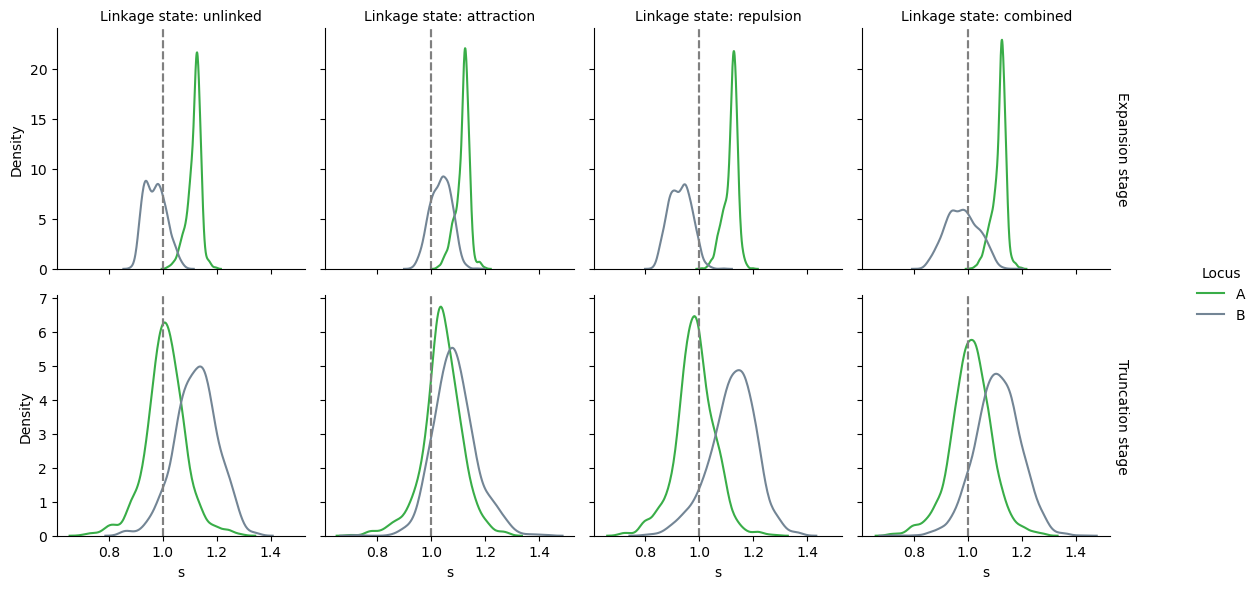

In [39]:
g = sns.FacetGrid(
    data=dplot,
    row="stage",
    col="linkage",
    hue="Locus",
    col_order=["unlinked", "attraction", "repulsion", "combined"],
    palette=palette,
    sharex=True,
    sharey="row",
    margin_titles=True,
)

g.map_dataframe(sns.kdeplot, x="s", alpha=1)
g.add_legend()

g.refline(x=1.0)

g.set_titles(row_template="{row_name} stage", col_template="Linkage state: {col_name}")

g.savefig("submission_plots/fitness_composite.pdf", bbox_inches="tight")
g.savefig("submission_plots/fitness_composite.png", dpi=600, bbox_inches="tight")